In [1]:
# 超解像: 評価指標は 'PSNR'
# SRCNN　を実装する
import os
import cv2
import numpy as np

In [2]:
def load_images(inputpath, imagesize, type_color):
    imglist = []
    
    exclude_prefixes = ('_', '.')
    
    # os.walk: directly内を走査、　現在のdirectly, 内包するdiredtly, 内包するfileを　roop
    # で返す
    for root, dirs, files in os.walk(inputpath):
        dirs[:] = [dir for dir in dirs if not dir.startswith(exclude_prefixes)]
        files[:] = [file for file in files if not file.startswith('.')]
        
        for fn in sorted(files):
            bn, ext = os.path.splitext(fn)
            if ext not in ['.bmp', '.BMP', '.jpg', '.JPG', '.jpeg', 
                           '.JPEG', '.png', '.PNG']:
                continue
            
            filename = os.path.join(root, fn)
            
            if type_color == 'Color':
                testimage = cv2.imread(filename, cv2.IMREAD_COLOR)
                hight, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, (imagesize, imagesize),
                                      interpolation=cv2.INTER_AREA)
                testimage = np.asarray(testimage, dtype=np.float64)
                testimage = testimage[:,:,::-1]
                
            elif type_color == 'Gray':
                testimage = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                hight, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, (imagesize, imagesize),
                                      interpolation=cv2.INTER_AREA)
                testimage = np.asarray(testimage, dtype=np.float64)
                testimage = np.asarray(testimage, dtype=np.float64).reshape((imagesize, imagesize, 1))
                
            imglist.append(testimage)
        
        imgsdata = np.asarray(imglist, dtype=np.float32)
        
        return imgsdata, sorted(files)

In [3]:
def genarate_lowersolution(imagelist, scale):
    
    imagelist_out = []
    
    for i in range(len(imagelist)):
        height, width = imagelist[i].shape[:2]
        image_tmp = cv2.resize(imagelist[i], (round(height/scale), round(height/scale))
                              , interpolation=cv2.INTER_AREA)
        image_tmp = cv2.resize(image_tmp, (height, width),
                              interpolation=cv2.INTER_AREA)
        imagelist_out.append(image_tmp)
        
    imagesdata = np.asarray(imagelist_out, dtype=np.float32)
    
    return imagesdata

In [12]:
def save_images(savepath, filenamelist, imagelist):
    for i, fn in enumerate(filenamelist):
        filename = os.path.join(savepath, fn)
        testimage = imagelist[i]
        #testimage = testimage[:,:,::-1]
        cv2.imwrite(filename, testimage)

In [14]:
image_train, image_train_filenames = load_images('./chapter8_dataset/SuperResolution01_RGB/train/org', 256, 'Gray')
image_test, image_test_filenames = load_images('./chapter8_dataset/SuperResolution01_RGB/test/org', 256, 'Gray')

image_train = genarate_lowersolution(image_train, 3.0)
image_test = genarate_lowersolution(image_test, 3.0)

save_images('./chapter8_dataset/SuperResolution01_RGB/train/train_low', image_train_filenames
           , image_train)

save_images('./chapter8_dataset/SuperResolution01_RGB/test/test_low', image_test_filenames
           , image_test)

In [15]:
IMAGE_SIZE = 256

imagelow_train, imagelow_train_filenames = load_images('./chapter8_dataset/SuperResolution01_RGB/train/train_low',
                                                      IMAGE_SIZE, 'Gray')
imagehigh_train, imagehigh_train_filenames = load_images('./chapter8_dataset/SuperResolution01_RGB/train/org',
                                                        IMAGE_SIZE, 'Gray')

imagelow_test, imagelow_test_filenames = load_images('./chapter8_dataset/SuperResolution01_RGB/test/test_low',
                                                      IMAGE_SIZE, 'Gray')
imagehigh_test, imagehigh_test_filenames = load_images('./chapter8_dataset/SuperResolution01_RGB/test/org',
                                                        IMAGE_SIZE, 'Gray')

imagelow_train /= 255
imagehigh_train /= 255
imagelow_test /= 255
imagehigh_test /= 255

In [16]:
from keras.layers import Input, Conv2D
from keras.models import Model

C = 1

def network_srcnn():
    input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, C))
    
    x = Conv2D(64, kernel_size=9, activation='relu', padding='same')(input_img)
    x = Conv2D(32, kernel_size=1, activation='relu', padding='same')(x)
    x = Conv2D(1, kernel_size=5, padding='same')(x)
    
    model = Model(input_img, x)
    
    return model

model = network_srcnn()

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      5248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 1)       801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
import keras.optimizers as optimizers
from tensorflow.python.keras import backend as K

def psnr(y_true, y_pred):
    return -10 * K.log(K.mean(K.flatten((y_true - y_pred))**2))/np.log(10)

adam = optimizers.Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[psnr])

training = model.fit(imagelow_train, imagehigh_train, epochs=100, batch_size=10,
                    shuffle=True, validation_data=(imagelow_test, imagehigh_test), verbose=1)


Train on 197 samples, validate on 50 samples
Epoch 1/100
197/197 [==============================] - 11s 57ms/step - loss: 0.0495 - psnr: 16.8993 - val_loss: 0.0120 - val_psnr: 19.2102
Epoch 2/100
197/197 [==============================] - 11s 56ms/step - loss: 0.0056 - psnr: 22.8396 - val_loss: 0.0038 - val_psnr: 24.2613
Epoch 3/100
197/197 [==============================] - 11s 58ms/step - loss: 0.0029 - psnr: 25.4788 - val_loss: 0.0021 - val_psnr: 26.6830
Epoch 4/100
197/197 [==============================] - 11s 55ms/step - loss: 0.0016 - psnr: 28.2554 - val_loss: 0.0012 - val_psnr: 29.1911
Epoch 5/100
197/197 [==============================] - 11s 57ms/step - loss: 0.0011 - psnr: 29.5747 - val_loss: 9.0113e-04 - val_psnr: 30.4633
Epoch 6/100
197/197 [==============================] - 11s 55ms/step - loss: 7.4949e-04 - psnr: 31.3093 - val_loss: 7.1044e-04 - val_psnr: 31.5032
Epoch 7/100
197/197 [==============================] - 11s 55ms/step - loss: 5.4179e-04 - psnr: 32.7122 - va

Epoch 55/100
197/197 [==============================] - 11s 57ms/step - loss: 1.5166e-04 - psnr: 38.2572 - val_loss: 1.6085e-04 - val_psnr: 37.9615
Epoch 56/100
197/197 [==============================] - 11s 58ms/step - loss: 1.3963e-04 - psnr: 38.6311 - val_loss: 1.5911e-04 - val_psnr: 38.0091
Epoch 57/100
197/197 [==============================] - 12s 59ms/step - loss: 1.3628e-04 - psnr: 38.7412 - val_loss: 1.5645e-04 - val_psnr: 38.0839
Epoch 58/100
197/197 [==============================] - 11s 58ms/step - loss: 1.3403e-04 - psnr: 38.7866 - val_loss: 1.5440e-04 - val_psnr: 38.1417
Epoch 59/100
197/197 [==============================] - 12s 59ms/step - loss: 1.3295e-04 - psnr: 38.8266 - val_loss: 1.5271e-04 - val_psnr: 38.1902
Epoch 60/100
197/197 [==============================] - 11s 58ms/step - loss: 1.3165e-04 - psnr: 38.9007 - val_loss: 1.5115e-04 - val_psnr: 38.2351
Epoch 61/100
197/197 [==============================] - 12s 59ms/step - loss: 1.3063e-04 - psnr: 38.9132 - val_l

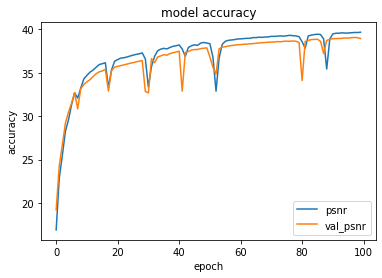

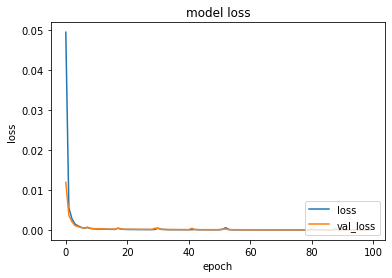

In [20]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['psnr'])
    plt.plot(history.history['val_psnr'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['psnr', 'val_psnr'], loc='lower right')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()
    
plot_history(training) 